In [1]:
!pip install -q memory_profiler psutil

import time
import random
import tracemalloc
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

random.seed(42)
np.random.seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)


In [2]:
def measure_time_and_memory(func, *args, repeat=3, warmup=1, **kwargs):
    times = []
    mems = []
    last_result = None

    for _ in range(warmup):
        try:
            func(*args, **kwargs)
        except:
            pass

    for _ in range(repeat):
        tracemalloc.start()
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        t1 = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        times.append(t1 - t0)
        mems.append(peak / (1024*1024))
        last_result = result

    return {
        'time_mean': float(np.mean(times)),
        'time_std': float(np.std(times)),
        'mem_mean_mb': float(np.mean(mems)),
        'mem_std_mb': float(np.std(mems)),
        'result': last_result
    }


In [3]:
# Fibonacci recursive
def fib_recursive_with_depth(n):
    max_depth = 0
    sys.setrecursionlimit(10000)
    def _fib(k, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)
        if k <= 1:
            return k
        return _fib(k-1, depth+1) + _fib(k-2, depth+1)
    val = _fib(n, 1)
    return {'value': val, 'max_recursion_depth': max_depth}

# Fibonacci DP
def fib_dp(n):
    if n <= 1:
        return {'value': n, 'max_recursion_depth': 1}
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a+b
    return {'value': b, 'max_recursion_depth': 1}

# Merge Sort
def merge_sort_with_depth(arr):
    max_depth = 0
    def _merge(a, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)
        if len(a) <= 1:
            return a
        mid = len(a)//2
        left = _merge(a[:mid], depth+1)
        right = _merge(a[mid:], depth+1)
        i = j = 0
        merged = []
        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                merged.append(left[i]); i+=1
            else:
                merged.append(right[j]); j+=1
        merged.extend(left[i:]); merged.extend(right[j:])
        return merged
    sorted_arr = _merge(list(arr), 1)
    return {'sorted': sorted_arr, 'max_recursion_depth': max_depth}

# Quick Sort
def quick_sort_with_depth(arr):
    max_depth = 0
    def _quick(a, low, high, depth):
        nonlocal max_depth
        if low >= high:
            max_depth = max(max_depth, depth)
            return
        max_depth = max(max_depth, depth)
        pivot_idx = random.randint(low, high)
        a[pivot_idx], a[high] = a[high], a[pivot_idx]
        pivot = a[high]
        i = low
        for j in range(low, high):
            if a[j] <= pivot:
                a[i], a[j] = a[j], a[i]; i+=1
        a[i], a[high] = a[high], a[i]
        _quick(a, low, i-1, depth+1)
        _quick(a, i+1, high, depth+1)
    a_copy = list(arr)
    _quick(a_copy, 0, len(a_copy)-1, 1)
    return {'sorted': a_copy, 'max_recursion_depth': max_depth}

# Insertion Sort
def insertion_sort(arr):
    a = list(arr)
    for i in range(1, len(a)):
        key = a[i]
        j = i-1
        while j >= 0 and a[j] > key:
            a[j+1] = a[j]
            j -= 1
        a[j+1] = key
    return {'sorted': a}

# Bubble Sort
def bubble_sort(arr):
    a = list(arr)
    n = len(a)
    for i in range(n):
        swapped = False
        for j in range(0, n-i-1):
            if a[j] > a[j+1]:
                a[j], a[j+1] = a[j+1], a[j]
                swapped = True
        if not swapped:
            break
    return {'sorted': a}

# Selection Sort
def selection_sort(arr):
    a = list(arr)
    n = len(a)
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            if a[j] < a[min_idx]:
                min_idx = j
        a[i], a[min_idx] = a[min_idx], a[i]
    return {'sorted': a}

# Binary Search
def binary_search(arr, target):
    lo, hi = 0, len(arr)-1
    steps = 0
    while lo <= hi:
        mid = (lo+hi)//2
        steps += 1
        if arr[mid] == target:
            return {'index': mid, 'steps': steps}
        elif arr[mid] < target:
            lo = mid+1
        else:
            hi = mid-1
    return {'index': -1, 'steps': steps}


In [4]:
print('fib_recursive(6):', fib_recursive_with_depth(6))
print('fib_dp(30):', fib_dp(30)['value'])
print('merge_sort example:', merge_sort_with_depth([3,1,4,2])['sorted'])
print('quick_sort example:', quick_sort_with_depth([5,2,9,1,5])['sorted'])
print('insertion sort example:', insertion_sort([4,2,1,3])['sorted'])
print('binary search example:', binary_search([1,2,3,4,5], 3))


fib_recursive(6): {'value': 8, 'max_recursion_depth': 6}
fib_dp(30): 832040
merge_sort example: [1, 2, 3, 4]
quick_sort example: [1, 2, 5, 5, 9]
insertion sort example: [1, 2, 3, 4]
binary search example: {'index': 2, 'steps': 1}


In [5]:
def run_sort_experiment(sort_fn, sizes, trials=3, kind='random'):
    results = []
    for n in sizes:
        if kind == 'random':
            base = [random.randint(0, 10**6) for _ in range(n)]
        elif kind == 'sorted':
            base = list(range(n))
        elif kind == 'reversed':
            base = list(range(n,0,-1))
        stats = measure_time_and_memory(sort_fn, base, repeat=trials)
        res = stats['result']
        rec_depth = None
        if isinstance(res, dict) and 'max_recursion_depth' in res:
            rec_depth = res['max_recursion_depth']
        results.append({
            'n': n,
            'time_mean_s': stats['time_mean'],
            'mem_mean_mb': stats['mem_mean_mb'],
            'recursion_depth': rec_depth
        })
        print(f'[{sort_fn.__name__}] n={n} time={stats["time_mean"]:.4f}s')
    return pd.DataFrame(results)

def run_fib_experiment(impl_fn, ns, trials=3):
    results = []
    for n in ns:
        stats = measure_time_and_memory(impl_fn, n, repeat=trials)
        res = stats['result']
        rec_depth = res.get('max_recursion_depth') if isinstance(res, dict) else None
        results.append({
            'n': n,
            'time_mean_s': stats['time_mean'],
            'mem_mean_mb': stats['mem_mean_mb'],
            'recursion_depth': rec_depth
        })
        print(f'[{impl_fn.__name__}] n={n} time={stats["time_mean"]:.6f}s')
    return pd.DataFrame(results)

def run_binary_search_experiment(sizes, trials=3):
    rows = []
    for n in sizes:
        arr = list(range(n))
        target = n//2
        stats = measure_time_and_memory(binary_search, arr, target, repeat=trials)
        res = stats['result']
        rows.append({
            'n': n,
            'time_mean_s': stats['time_mean'],
            'mem_mean_mb': stats['mem_mean_mb'],
            'steps': res.get('steps')
        })
        print(f'[binary_search] n={n} time={stats["time_mean"]:.6f}s')
    return pd.DataFrame(rows)


In [6]:
SORT_SIZES_QUICK_MERGE = [500, 1000, 2000, 4000]
SORT_SIZES_QUADRATIC = [100, 200, 500, 1000]
BINARY_SEARCH_SIZES = [10000, 20000, 50000]
FIB_RECURSIVE_NS = [5, 10, 15, 20, 25]
FIB_DP_NS = [1000, 5000, 10000]


In [7]:
df_merge = run_sort_experiment(merge_sort_with_depth, SORT_SIZES_QUICK_MERGE)
df_quick = run_sort_experiment(quick_sort_with_depth, SORT_SIZES_QUICK_MERGE)
df_insertion = run_sort_experiment(insertion_sort, SORT_SIZES_QUADRATIC)
df_bubble = run_sort_experiment(bubble_sort, SORT_SIZES_QUADRATIC)
df_selection = run_sort_experiment(selection_sort, SORT_SIZES_QUADRATIC)

df_fib_rec = run_fib_experiment(fib_recursive_with_depth, FIB_RECURSIVE_NS, trials=1)
df_fib_dp = run_fib_experiment(fib_dp, FIB_DP_NS)

df_binary = run_binary_search_experiment(BINARY_SEARCH_SIZES)


[merge_sort_with_depth] n=500 time=0.0084s
[merge_sort_with_depth] n=1000 time=0.0143s
[merge_sort_with_depth] n=2000 time=0.0340s
[merge_sort_with_depth] n=4000 time=0.0857s
[quick_sort_with_depth] n=500 time=0.0094s
[quick_sort_with_depth] n=1000 time=0.0260s
[quick_sort_with_depth] n=2000 time=0.0622s
[quick_sort_with_depth] n=4000 time=0.1449s
[insertion_sort] n=100 time=0.0002s
[insertion_sort] n=200 time=0.0007s
[insertion_sort] n=500 time=0.0517s
[insertion_sort] n=1000 time=0.4128s
[bubble_sort] n=100 time=0.0006s
[bubble_sort] n=200 time=0.0022s
[bubble_sort] n=500 time=0.1271s
[bubble_sort] n=1000 time=1.5135s
[selection_sort] n=100 time=0.0004s
[selection_sort] n=200 time=0.0013s
[selection_sort] n=500 time=0.0883s
[selection_sort] n=1000 time=0.4562s
[fib_recursive_with_depth] n=5 time=0.000036s
[fib_recursive_with_depth] n=10 time=0.000224s
[fib_recursive_with_depth] n=15 time=0.002635s
[fib_recursive_with_depth] n=20 time=0.027532s
[fib_recursive_with_depth] n=25 time=0.3

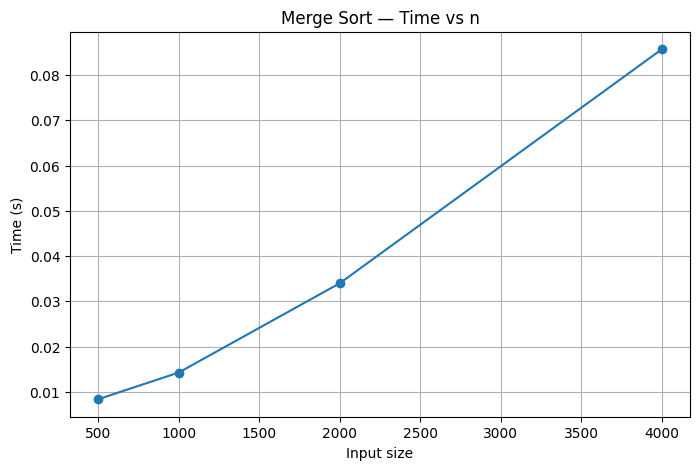

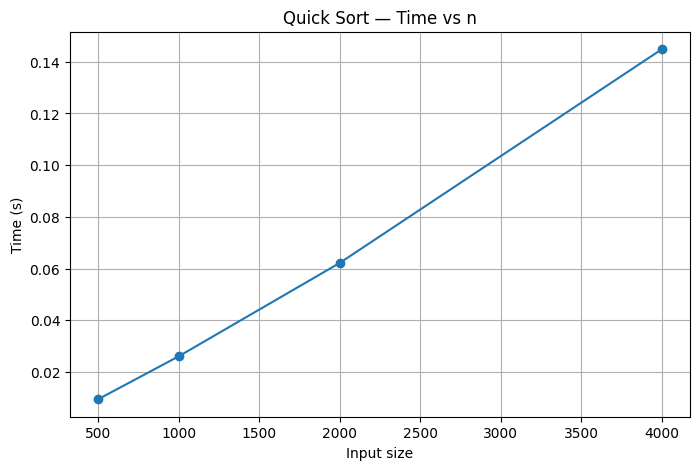

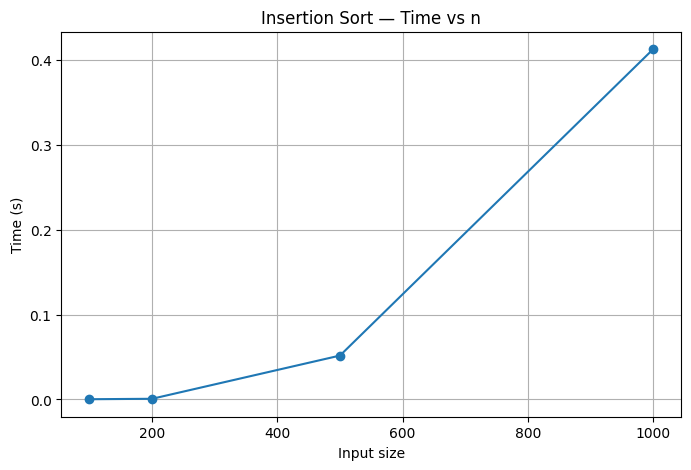

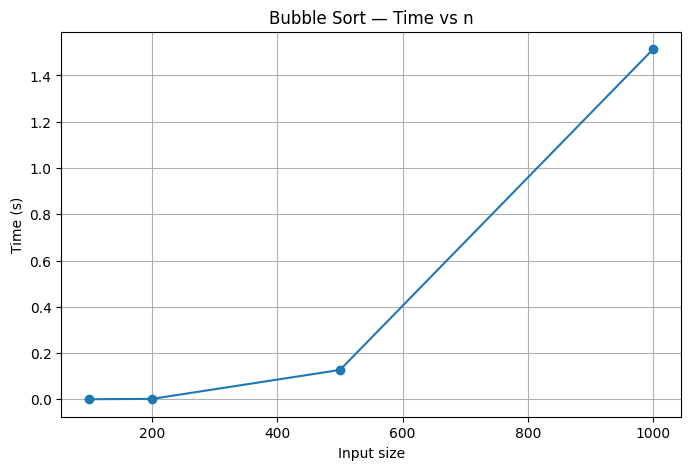

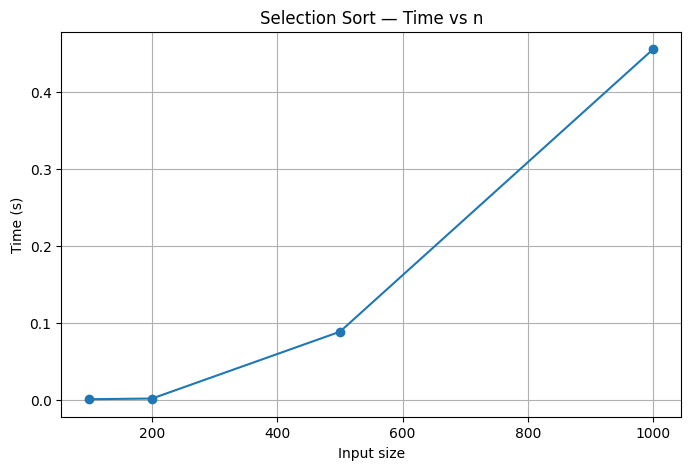

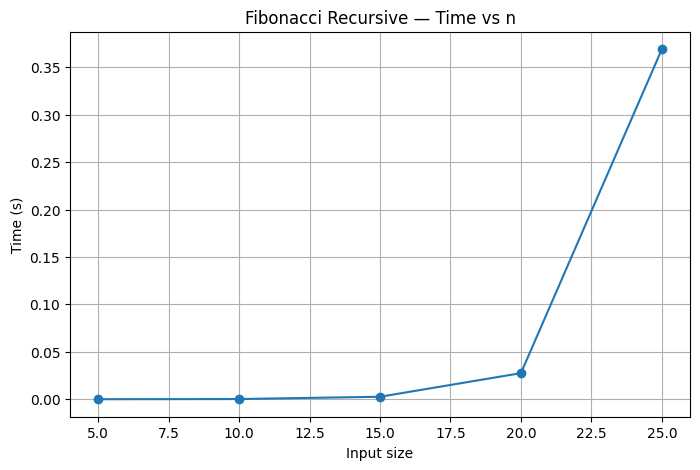

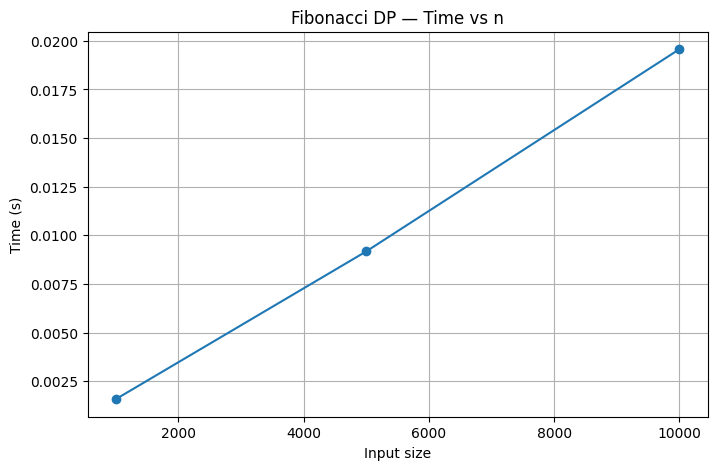

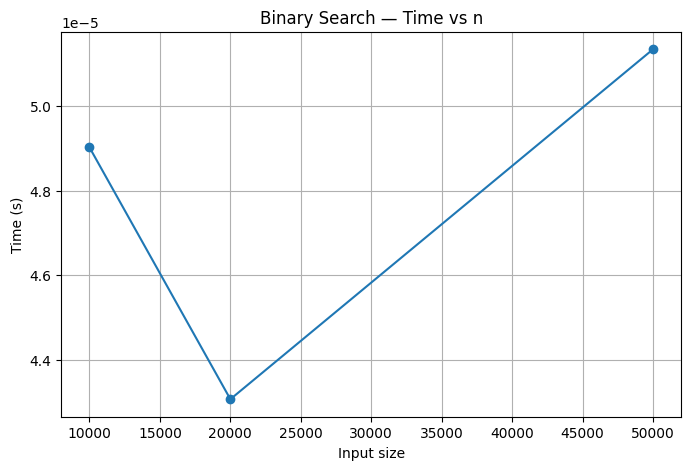

In [8]:
def plot_time(df, name):
    plt.plot(df['n'], df['time_mean_s'], marker='o')
    plt.xlabel('Input size')
    plt.ylabel('Time (s)')
    plt.title(name + ' — Time vs n')
    plt.grid(True)
    plt.show()

plot_time(df_merge, 'Merge Sort')
plot_time(df_quick, 'Quick Sort')
plot_time(df_insertion, 'Insertion Sort')
plot_time(df_bubble, 'Bubble Sort')
plot_time(df_selection, 'Selection Sort')
plot_time(df_fib_rec, 'Fibonacci Recursive')
plot_time(df_fib_dp, 'Fibonacci DP')
plot_time(df_binary, 'Binary Search')
